In [376]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [377]:
from lib.optimizers import *
from lib.functions import *
import numpy as np
import matplotlib.pyplot as plt

### Helper functions

In [378]:
_infty = 1e16
_zero = 1e-32

def remove_nans_infs_and_zeros(arr):
    arr = np.array(arr)
    arr[np.isnan(arr)] = _infty
    arr[np.isinf(arr)] = _infty
    arr[arr > _infty] = _infty
    arr[arr == 0] = _zero
    arr[arr < _zero] = _zero
    return arr

# A neural network

In [379]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [380]:
def F(x, p, layers):
    assert x.shape[0] == layers[0]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = x
    for i in range(len(layers) - 1):
        a = sigmoid(W[i] @ a + b[i])
    y = a
    
    assert y.shape[0] == layers[-1]
    
    return y

In [381]:
def f(p, layers, X, Y):
    res = np.array([np.linalg.norm(F(x, p, layers) - y) for x, y in zip(X, Y)])
    return res

In [382]:
def grad_C(p, layers, x, y):
    assert x.shape[0] == layers[0]
    assert y.shape[0] == layers[-1]
    
    W = []
    b = []
    index = 0
    for i in range(len(layers) - 1):
        W.append(p[index:index + layers[i] * layers[i + 1]].reshape((layers[i + 1], layers[i])))
        index += layers[i] * layers[i + 1]
    for i in range(len(layers) - 1):
        b.append(p[index:index + layers[i + 1]])
        index += layers[i + 1]
    
    a = [x]
    z = []
    for i in range(len(layers) - 1):
        z.append(W[i] @ a[i] + b[i])
        a.append(sigmoid(z[i]))
    
    delta = [sigmoid(z[-1]) * (1 - sigmoid(z[-1])) * (a[-1] - y)]
    for i in range(len(layers) - 2, 0, -1):
        delta.append(sigmoid(z[i - 1]) * (1 - sigmoid(z[i - 1])) * (W[i].T @ delta[-1]))
    delta = delta[::-1]
    
    grad_W = []
    for i in range(len(layers) - 1):
        grad_W.append(delta[i].reshape((layers[i + 1], 1)) @ a[i].reshape((1, layers[i])))
    
    grad_b = delta
    
    grad = np.concatenate(([grad_W[i].flatten() for i in range(len(grad_W))] + [grad_b[i] for i in range(len(grad_b))]))
    
    assert grad.shape == p.shape
    
    return grad

# Data

$X_i$ - random 2 dimentional vector with entries from -50 to 50

$Y_i$ - sum of entries of $X$ is greater than or equal 0

In [383]:
num_samples = 300
X = 100 * np.random.rand(num_samples, 2) - 50
Y = np.vstack(((X[:, 0] + X[:, 1] >= 0).astype(float), (X[:, 0] + X[:, 1] < 0).astype(float))).T
X[:5, :], Y[:5, :]

(array([[-27.87373148, -35.87360951],
        [-40.27400729,  48.40422414],
        [-23.96590724,   3.70225214],
        [ -5.20738281, -40.04309109],
        [-14.76883388,  -3.0750826 ]]),
 array([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]))

## The function

In [384]:
layers = [2, 4, 4, 2]

def r(p):
    return f(p, layers, X, Y)

def Dr(p):
    return np.vstack([grad_C(p, layers, x, y) for x, y in zip(X, Y)])

N = X.shape[0]
M = 0
for i in range(len(layers) - 1):
    M += layers[i] * layers[i + 1]
for i in range(len(layers) - 1):
    M += layers[i + 1]
M, N

(42, 300)

In [385]:
R = Function(F=r, DF=Dr, M=M, N=N)

# Test different methods

In [404]:
np.random.seed(0)
p0 = np.random.randn(M)
max_iter = 100
alpha_gn = 1e1
max_iter_gd = 100
alpha_gd = 1e-3

In [387]:
np.linalg.norm(R(p0))

13.395177280469479

## Stochastic gradient

In [388]:
p = p0

for epoch in range(max_iter_gd):
    i = np.random.randint(0, len(X))
    x, y = X[i,:], Y[i]
    p = p - alpha_gd * N * grad_C(p, layers, x, y)
    
err = np.linalg.norm(R(p))
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=1.3021012046780314
err=11.490964951765832


## Gradient descent

In [389]:
p, err = gradient_descent(R, p0, alpha_gd, max_iter_gd)
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=1.0554464822151046
err=11.763434704233353


## Gauss-Newton

In [390]:
p, err = gauss_newton(R=R, p0=p0, max_iter=max_iter, alpha=alpha_gn, step_type="least_squares")
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

<ipython-input-379-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


|p-p0|=8.21748610560456e+59
err=17.262676501632072


## Levenberg-Marquardt

#### 1. Constant $\lambda_k$ sequence

In [391]:
lambda_param = 1.
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
)

In [392]:
p, err = optimizer.optimize(p0, max_iter, step_type="cholesky")
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=11.747235804817116
err=2.681687949542925


In [393]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=6, step_tol=1e-6)
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=11.883948541304921
err=2.5278194707723634


In [394]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=11.196195678962933
err=1.7502892872436089


#### 2. Sequence $\lambda_k$ decrasing when error is decreasing, and increasing otherwise

In [395]:
lambda_param = 1.
lambda_change = 2.
optimizer = LevenbergMarquardt(
    R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=lambda_change)
)

In [396]:
p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=6, step_tol=1e-6)
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=8.142474103313077
err=1.2191924420556386


In [397]:
p, err = optimizer.optimize(p0, max_iter, step_type="svd")
print(f"|p-p0|={np.linalg.norm(p-p0)}\n{err=}")

|p-p0|=8.822405123912644
err=1.4807281391223037


# Tests

# Test lambda/alpha parameters

In [398]:
lambda_params = [float(10**(2*i)) for i in range(-6, 2)]
np.random.seed(42)
p0s = [4**i * np.random.randn(M) for i in range(3)]
max_iter = 10
max_iter_gd = 100
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, lambda_param in enumerate(lambda_params):
    print(f"lambda/alpha param: {lambda_param} ({i + 1}/{len(lambda_params)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda_param)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda_param, lambda_change=2)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=lambda_param, max_iter=max_iter_gd)
        errs.append(err)
    errors_gradient_descent.append(errs)

lambda/alpha param: 1e-12 (1/8)


<ipython-input-379-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


lambda/alpha param: 1e-10 (2/8)
lambda/alpha param: 1e-08 (3/8)
lambda/alpha param: 1e-06 (4/8)
lambda/alpha param: 0.0001 (5/8)
lambda/alpha param: 0.01 (6/8)
lambda/alpha param: 1.0 (7/8)
lambda/alpha param: 100.0 (8/8)


In [399]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

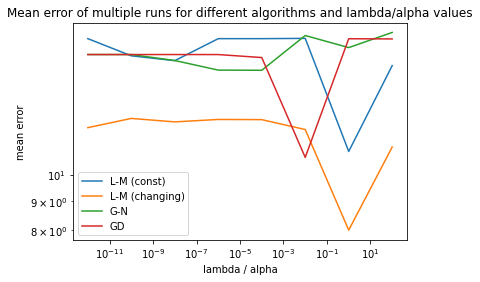

In [400]:
plt.loglog(lambda_params, errors_mean_lm_const, label="L-M (const)")
plt.loglog(lambda_params, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(lambda_params, errors_gn_mean, label="G-N")
plt.loglog(lambda_params, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("lambda / alpha")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and lambda/alpha values")
plt.show()

# Test number of iterations

In [401]:
max_iters = [2**i for i in range(0, 6)]
np.random.seed(42)
p0s = [4**i * np.random.randn(M) for i in range(3)]
alpha_gd = 1e-2
alpha_gn = 1e-4
lambda0 = 1.
lambda_change = 1.1
step_max_iter = 10
step_tol = 1e-6

errors_levenberg_marquardt_const_param = []
errors_levenberg_marquardt_modifying_param = []
errors_gauss_newton = []
errors_gradient_descent = []

for i, max_iter in enumerate(max_iters):
    print(f"max_iter: {max_iter} ({i + 1}/{len(max_iters)})")
    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamConstant(lambda0=lambda0)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_const_param.append(errs)

    optimizer = LevenbergMarquardt(
        R=R, lambda_param_fun=LevenbergMarquardt.LambdaParamDefaultModifier(lambda0=lambda0, lambda_change=lambda_change)
    )

    errs = []
    for p0 in p0s:
        p, err = optimizer.optimize(p0, max_iter, step_type="cgnr", step_max_iter=step_max_iter, step_tol=step_tol)
        errs.append(err)
    errors_levenberg_marquardt_modifying_param.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gauss_newton(R=R, p0=p0, alpha=alpha_gn, max_iter=max_iter)
        errs.append(err)
    errors_gauss_newton.append(errs)

    errs = []
    for p0 in p0s:
        p, err = gradient_descent(R=R, p0=p0, alpha=alpha_gd, max_iter=max_iter)
        errs.append(err)
    errors_gradient_descent.append(errs)

max_iter: 1 (1/6)


<ipython-input-379-dc64dee5606b>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


max_iter: 2 (2/6)
max_iter: 4 (3/6)
max_iter: 8 (4/6)
max_iter: 16 (5/6)
max_iter: 32 (6/6)


In [402]:
errors_mean_lm_const = np.mean(errors_levenberg_marquardt_const_param, axis=1)
errors_mean_lm_const = remove_nans_infs_and_zeros(errors_mean_lm_const)

errors_mean_lm_mod = np.mean(errors_levenberg_marquardt_modifying_param, axis=1)
errors_mean_lm_mod = remove_nans_infs_and_zeros(errors_mean_lm_mod)

errors_gn_mean = np.mean(errors_gauss_newton, axis=1)
errors_gn_mean = remove_nans_infs_and_zeros(errors_gn_mean)

errors_gd_mean = np.mean(errors_gradient_descent, axis=1)
errors_gd_mean = remove_nans_infs_and_zeros(errors_gd_mean)

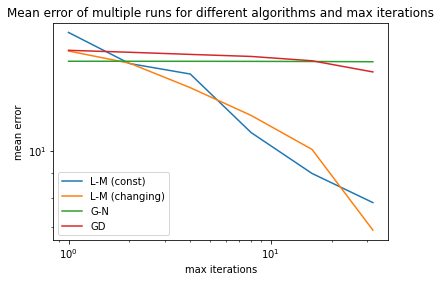

In [403]:
plt.loglog(max_iters, errors_mean_lm_const, label="L-M (const)")
plt.loglog(max_iters, errors_mean_lm_mod, label="L-M (changing)")
plt.loglog(max_iters, errors_gn_mean, label="G-N")
plt.loglog(max_iters, errors_gd_mean, label="GD")

plt.legend()
plt.xlabel("max iterations")
plt.ylabel("mean error")
plt.title("Mean error of multiple runs for different algorithms and max iterations")
plt.show()